# Exercise 2 - Neural network regression


# 1

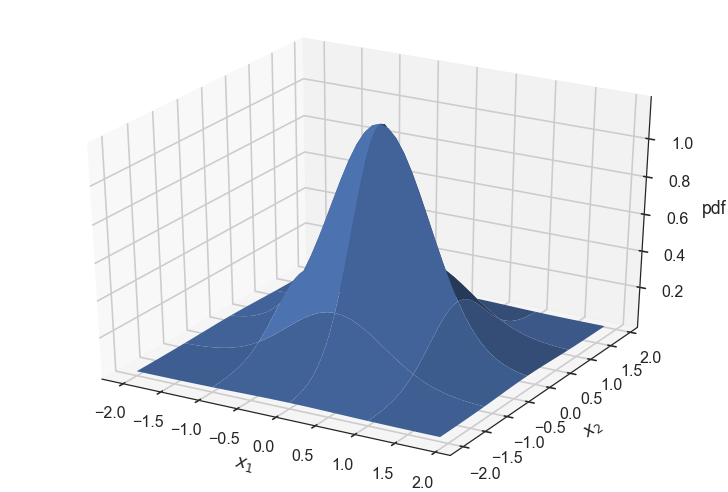

In [15]:
import numpy as np
import seaborn as sb
from scipy.stats import multivariate_normal as mv
from mpl_toolkits.mplot3d import Axes3D
from pylab import *

# q1
# create the target distribution
# sample at .1 interval
tmp = np.arange(-2, 2, .1)
x, y = np.meshgrid(tmp, tmp)

mu = [0,0]
sigma = np.eye(len(mu)) * 2/5
dist = mv(mu, sigma)

X = np.vstack((x.flatten(), y.flatten())).T
Y = dist.pdf(X).reshape(x.shape)  * 3
targets = np.array(Y.flatten(), ndmin = 2).T

fig, ax = subplots(1,1, subplot_kw = {'projection': '3d'})
ax.plot_surface(x, y, targets.reshape(x.shape))
ax.set_xlabel('$x_1$', labelpad = 20)
ax.set_ylabel('$x_2$', labelpad = 20)
ax.set_zlabel('pdf', labelpad =20)
sb.set_context('poster')
sb.set_style('white')
show()

# 2

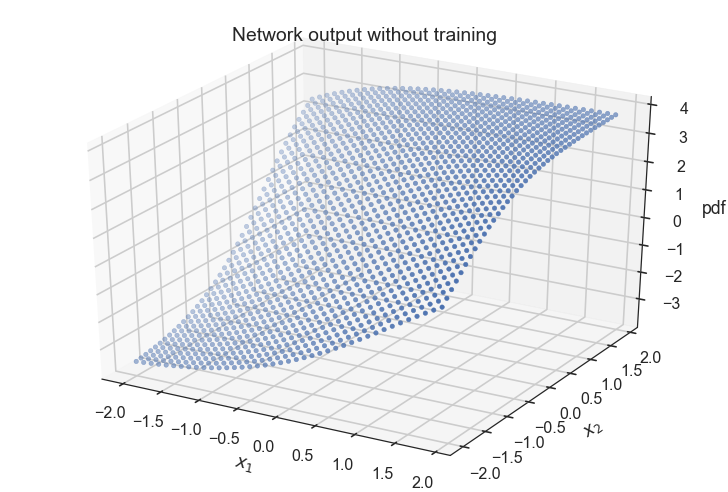

In [21]:
def mlp(X, t,\
        eta = 1e-1,\
        gamma = 0, \
        num = 1e3,\
        K = 1, \
        M = 8,\
        save = 250, init = 'go'):
    '''
    Multi-layered-pereptron
    K = output nodes
    M = hidden nodes
    Assumes the input data X is samples x feature dimension
    Returns:
        prediction and error
    '''
    num = int(num)
    # add bias node; note the bias is absorbed in the weights of the
    # second layer ()
    M = M #+ 1
    # input dimension; ass bias node
    D = X.shape[1] + 1
    # stack bias constant signal of ones
    X = np.hstack((X, np.ones((X.shape[0], 1))))
    # init weights
    # hidden weights and outputweights
    wh = np.random.rand(D, M) #- 1/2
    wo = np.random.rand(M, K) #- 1/2
    errors = np.zeros(num + 1)
    preds = []
    idx = 0
    for i in range(num + 1):
        error = 0
        predictions = zeros(t.shape)
        for jdx, (ti, xi) in enumerate(zip(t, X)):
            # convert to vector
            xi = array(xi, ndmin = 2)
            #forward pass
            a = xi.dot(wh); z = np.tanh(a); y = z.dot(wo)
            # backward pass
            dk = ti - y
            # compute hidden activation; note elementwise product!!
            dj = (1 - z**2) * ((wo.dot(dk.T).T))
            # update the weights
            E1 = z.T.dot(dk); E2 = xi.T.dot(dj)
            # update with momentum (if activated)
            # the first 
            if init == 'go':
                wo += eta * E1 + gamma * wo
                wh += eta * E2 + gamma * wh
            
            error += np.sum((dk)**2)
            # store the prediction
            predictions[jdx] = y
        # store error
        errors[i] = error
        # print(error)
        if error < 1e-1:
            print('error low enough')
            break
        if error == nan:
            print('nan encountered')
            break
        idx += 1
        if  idx  == save or i == 0:
#             print('pass', i)
            preds.append([predictions,i])
            idx = 0
    return errors, preds

# perform a single forward pass and show the results
errors, preds = mlp(X, targets, num = 0, init = None)

# plot the results
fig, ax = subplots(subplot_kw  = {'projection': '3d'})
ax.scatter(x, y, preds[0][0].reshape(x.shape))
ax.set_xlabel('$x_1$', labelpad = 20)
ax.set_ylabel('$x_2$', labelpad = 20)
ax.set_zlabel('pdf', labelpad =20)
ax.set_title('Network output without training')
sb.set_context('poster')
show()

# 3

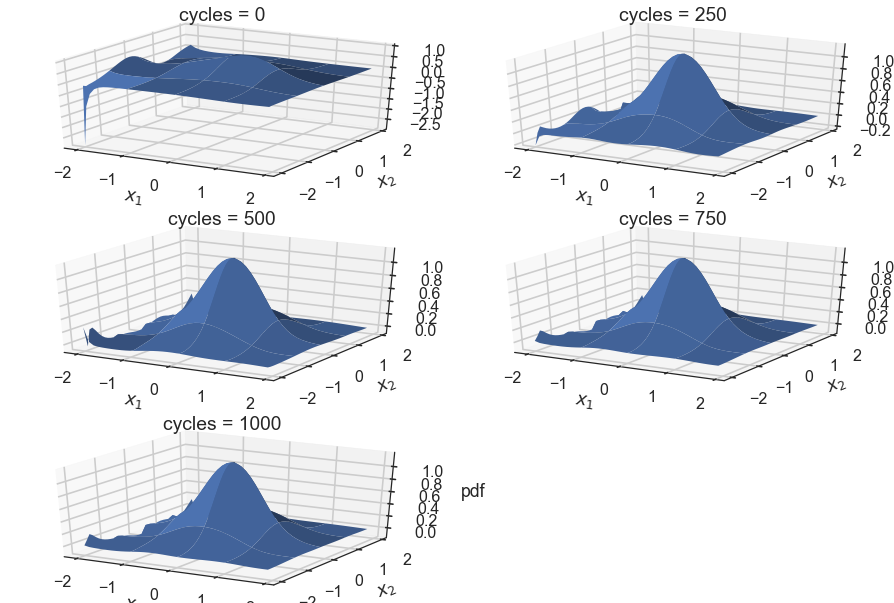

In [24]:
errors, preds = mlp(X, targets, num = 1e3)

# use at most 3 rows
nRows = 3
nCols = int(ceil(len(pred)/nRows))
fig, axes  = subplots(nRows, nCols, subplot_kw = {'projection': '3d'})
for idx, p in enumerate(pred):
    axes.flatten()[idx].plot_surface(x, y, preds[idx][0].reshape(x.shape))
    axes.flatten()[idx].set_xlabel('$x_1$', labelpad = 20)
    axes.flatten()[idx].set_ylabel('$x_2$', labelpad = 20)
    axes.flatten()[idx].set_zlabel('pdf', labelpad =20)
    axes.flatten()[idx].set_title('cycles = {0}'.format(pred[idx][1]))
    sb.set_style('white')
fig.delaxes(axes.flatten()[-1])
fig.tight_layout()
show()

# 4

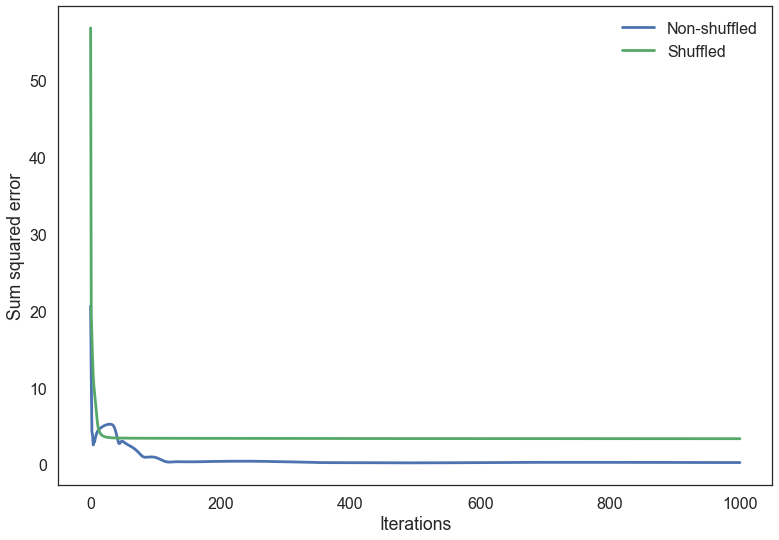

In [28]:
# shuffle the indices
idx = np.random.permutation(range(len(targets)))
# shuffle the data
shuffleX = X[idx,:]
# shuffle the targets as well (same indices)
shuffleTargets = targets[idx]
#  compute the preds etc
errors_shuff, preds = mlp(shuffleX, shuffleTargets)

fig, ax = subplots()
ax.plot(error, label = 'Non-shuffled')
ax.plot(errors_shuff, label = 'Shuffled')
ax.set_xlabel('Iterations')
ax.set_ylabel('Sum squared error')
ax.legend(loc = 0)
show()

Since the grid is linearly spaced, this will mean that nearby points will yield the same gradient in the error. This 'local' correlation will yield that the algorithm will change the weights in similar direction for a while, hence shuffling the data removes this 'local' correlation structure, yielding more likely to move in the different directions, constraining the algorithm, yielding faster convergence.

# 5 

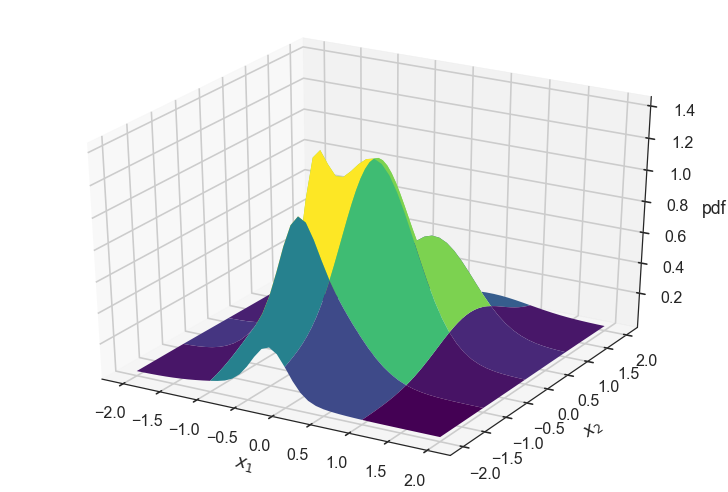

In [5]:
# load the data
X, Y, target = list(np.loadtxt('../Data/a017_NNpdfGaussMix.txt').T)
tmp = int(np.sqrt(target.shape[0]))
# convert in shape for it to be plottable 
x = X.reshape(tmp,tmp)

y = Y.reshape(tmp, tmp)
# stack to create input data
X = np.vstack((X,Y)).T

# target vector
target = np.array(target, ndmin = 2).T

fig, ax = subplots(1,1, subplot_kw = {'projection': '3d'})
ax.plot_surface(x, y, target.reshape(tmp, tmp), cmap = 'viridis')
ax.set_xlabel('$x_1$', labelpad = 20)
ax.set_ylabel('$x_2$', labelpad = 20)
ax.set_zlabel('pdf', labelpad =20)
show()

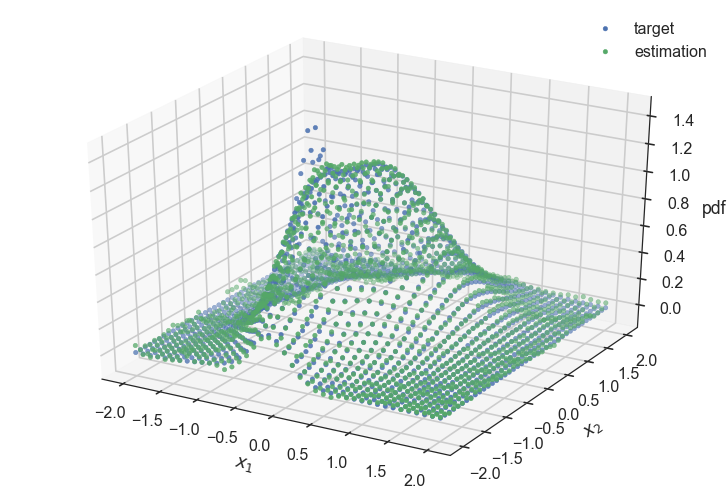

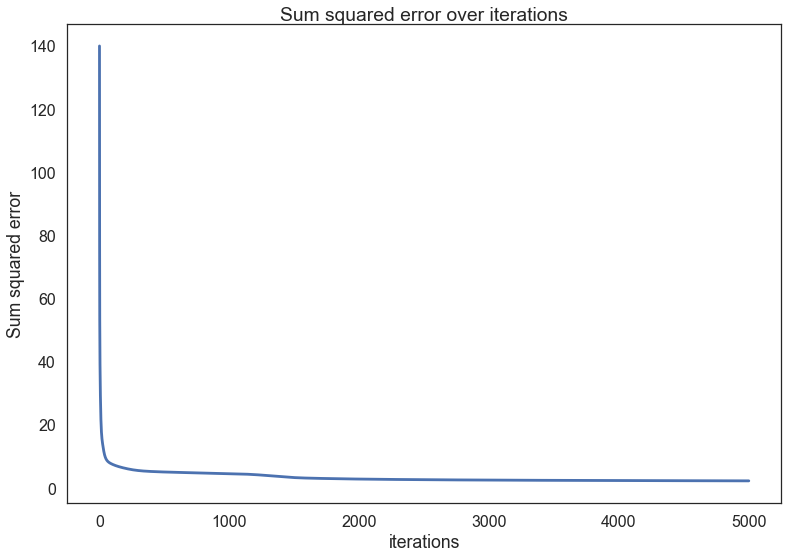

In [7]:
#randomly permute indices
idx = np.random.permutation(range(len(target)))
# keep track of the changes
shuffX = X[idx,:]; shuffTarget = target[idx].copy()
# run mlp
errors, preds = mlp(shuffX, shuffTarget,\
                    eta = 1e-2,\
                    num = 5e3,\
                    save = int(1e3),\
                    M = 40)
# map back to original space
orgIdx = argsort(idx)
# get final prediction
finalPred = preds[-1][0][orgIdx]

# plot the final prediction and the target distribution
fig, ax = subplots(subplot_kw = {'projection': '3d'})
ax.scatter(x, y, target.reshape(x.shape), label = 'target')
ax.scatter(x, y, finalPred.reshape(x.shape), label = 'estimation')
ax.set_xlabel('$x_1$', labelpad = 20)
ax.set_ylabel('$x_2$', labelpad = 20)
ax.set_zlabel('pdf', labelpad = 20)
ax.legend(loc = 0)

fig, ax = subplots()
ax.plot(errors)
ax.set_xlabel('iterations')
ax.set_ylabel('Sum squared error')
ax.set_title('Sum squared error over iterations')
show()

One might improve the performance by adding more hidden nodes to the network. The hidden nodes essentially represent the degrees of freedom in the model. Increasing the number of hidden nodes might increase the fit on a trainingset, however it will also increase the modelling noise (i.e overfitting). Improvements might also be found in presenting the inputs / targets in a different feature space. Multi-layered perceptrons are notorious for being sensitive to how the data is represented. Another might be instead of taking a global learning rate, is make it adaptive (see conjugate gradient descent, momentum etc). 

# 8

For the toolbox, we use the MLPclassifier from sklearn. Since the netlab is not avaiable for python.

In [ ]:
from sklearn.neural_network import MLPClassifier as mlpclsf
# keep same alpha for comparison
model = mlpclsf(alpha = 1e-5, activation = 'tanh')
print(target.shape)
model.fit(X, target.flatten())
